# Diffusion Map on "Swiss Roll"
This python notebook is based on the tutorial "Diffusion Maps: Embedding of an S-curved manifold" provided by the datafold documentation.
Source: https://datafold-dev.gitlab.io/datafold/tutorial_03_dmap_scurve.html

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Diffusion Maps: Embedding of a "swiss-roll" manifold

For a detailed introduction see paper 

Coifman and Lafon, Diffusion maps, Appl. Comput. Harmon. Anal. 21 (2006) 5–30, 2006, Available at: https://www.sciencedirect.com/science/article/pii/S1063520306000546

Diffusion Maps is an algorithm to "learn" (i.e. parametrize) a manifold from data (cf. "manifold learning"). The usual assumption is that the original point cloud is represented in a high-dimensional space (the ambient space), while the points lie close to a manifold with an intrinsically lower-dimension. Using the Diffusion Map algorithm we aim to parametrize this (hidden) manifold to obtain a parsimonious data representation.

The `DiffusionMaps` algorithm allows embedding the points into a lower-dimension and at the same time aims to preserve some quantities of interest such as local mutual distances. The Diffusion Map algorithm constructs a Markov Chain based on the available point cloud - the probabilities describe a diffusion process on the point cloud. The probabilities of the Markov Chain encode the locality: how probable a transition between two data points is in one time step of the process is. Finally, the eigenvectors of the Markov Chain matrix are the stationary solution with $t \rightarrow \infty$ and encode the new parsimonious representation.

Alternative manifold learning methods are, for example: Isomaps, Local Linear Embedding or Hessian eigenmaps. For a quick comparison, (without Diffusion Maps). See e.g.

http://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

**In this tutorial** we use the `PCManifold` to select suitable parameters (`epsilon` and `cut_off`), fit a `DiffusionMaps` model to learn the S-curved manifold (like in the scikit-learn link above) and in the last step we show how to find the "right" parsimonious representation automatically with `LocalRegressionSelection`.

In [9]:
# Imports
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3  # noqa: F401
import numpy as np
from sklearn.datasets import make_swiss_roll

import datafold.dynfold as dfold
import datafold.pcfold as pfold
from datafold.dynfold import LocalRegressionSelection
from datafold.utils.plot import plot_pairwise_eigenvector

import model

## Generate "swiss-roll" point cloud  

We use the generator `make_s_curve` from scikit-learn. The points have a three-dimensional representation (ambient space) and the points lie on a (non-linear) S-curved shaped manifold with intrinsic dimension two (i.e. on the folded plane). The scikit-learn function also provides pseudo-colouring, which allows to better visualize different embeddings.

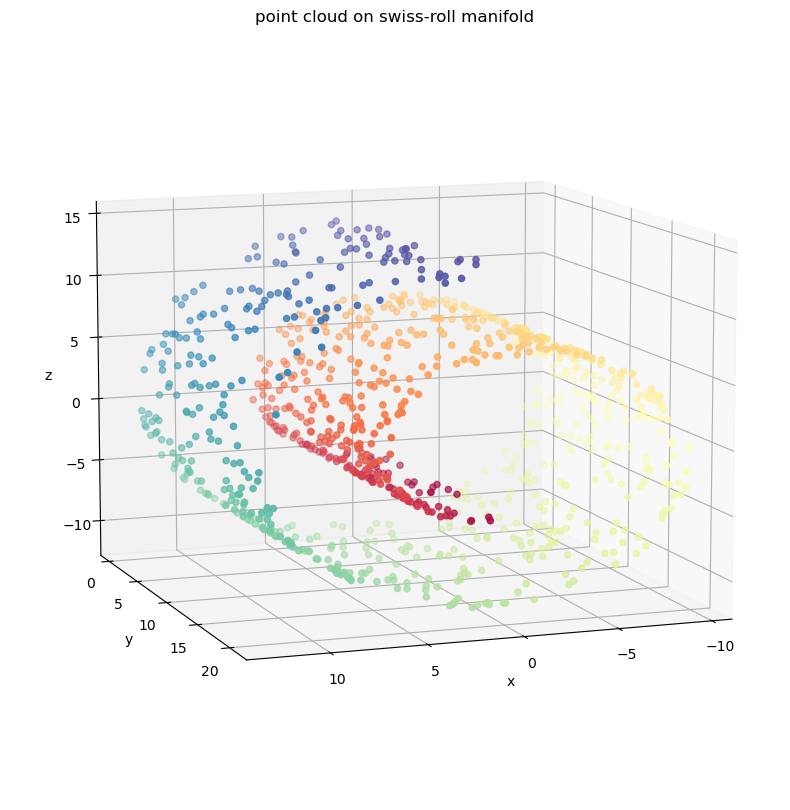

In [10]:
# Generate "swiss-roll" data
nr_samples = 5000

rng = np.random.default_rng(1)

# reduce number of points for plotting
nr_samples_plot = 1000
idx_plot = rng.permutation(nr_samples)[0:nr_samples_plot]

# generate point cloud
X, X_color = make_swiss_roll(nr_samples, random_state=3, noise=0)

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    X[idx_plot, 0],
    X[idx_plot, 1],
    X[idx_plot, 2],
    c=X_color[idx_plot],
    cmap=plt.cm.Spectral,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("point cloud on swiss-roll manifold")
ax.view_init(10, 70)

## Optimize kernel parameters 

We now use a `PCManifold` to estimate parameters. The attached kernel in `PCManifold` defaults to a `GaussianKernel`.

* `epsilon` - the scale of the Gaussian kernel
* `cut_off` - promotes kernel sparsity and allows the number of samples in a dataset to be scaled

In [11]:
X_pcm = pfold.PCManifold(X)
X_pcm.optimize_parameters()

print(f"epsilon={X_pcm.kernel.epsilon}, cut-off={X_pcm.cut_off}")

epsilon=0.5516060210474548, cut-off=3.187625826560739


## Fit DiffusionMaps model 

We first fit a `DiffusionMaps` model with the optimized parameters and then compare potential two-dimensional embeddings. For this we fix the first non-trivial eigenvector ($\psi_1$) and compare it to the other computed eigenvectors ($\{\psi\}_{i=1, i \neq 1}^{9}$). 

**Observations:**

* The first eigenvector $\psi_0$ (with eigenvalue 1) can usually be ignored if `is_stochastic=True` as it is constant (cf. a property of row-stochastic matrix).
* Pairings like $\psi_1$ and $\psi_2$ are good examples for a "functional dependence" between eigenvectors. Our aim for the S-curve is to unfold in a two-dimensional coordinate space. For pairings with a functional dependence, the embeddings are poor because the eigenvector ($\rightarrow$ eigenfunction) does not go along a new and independent direction compared to eigenvector $\psi_1$.  
* We identify the eigenvector pair $\psi_1$ and $\psi_5$ as the best choice. It does a good job to "unfold" the two dimensional S-curved manifold into now two-dimensional embedding space.

14.992957932497372


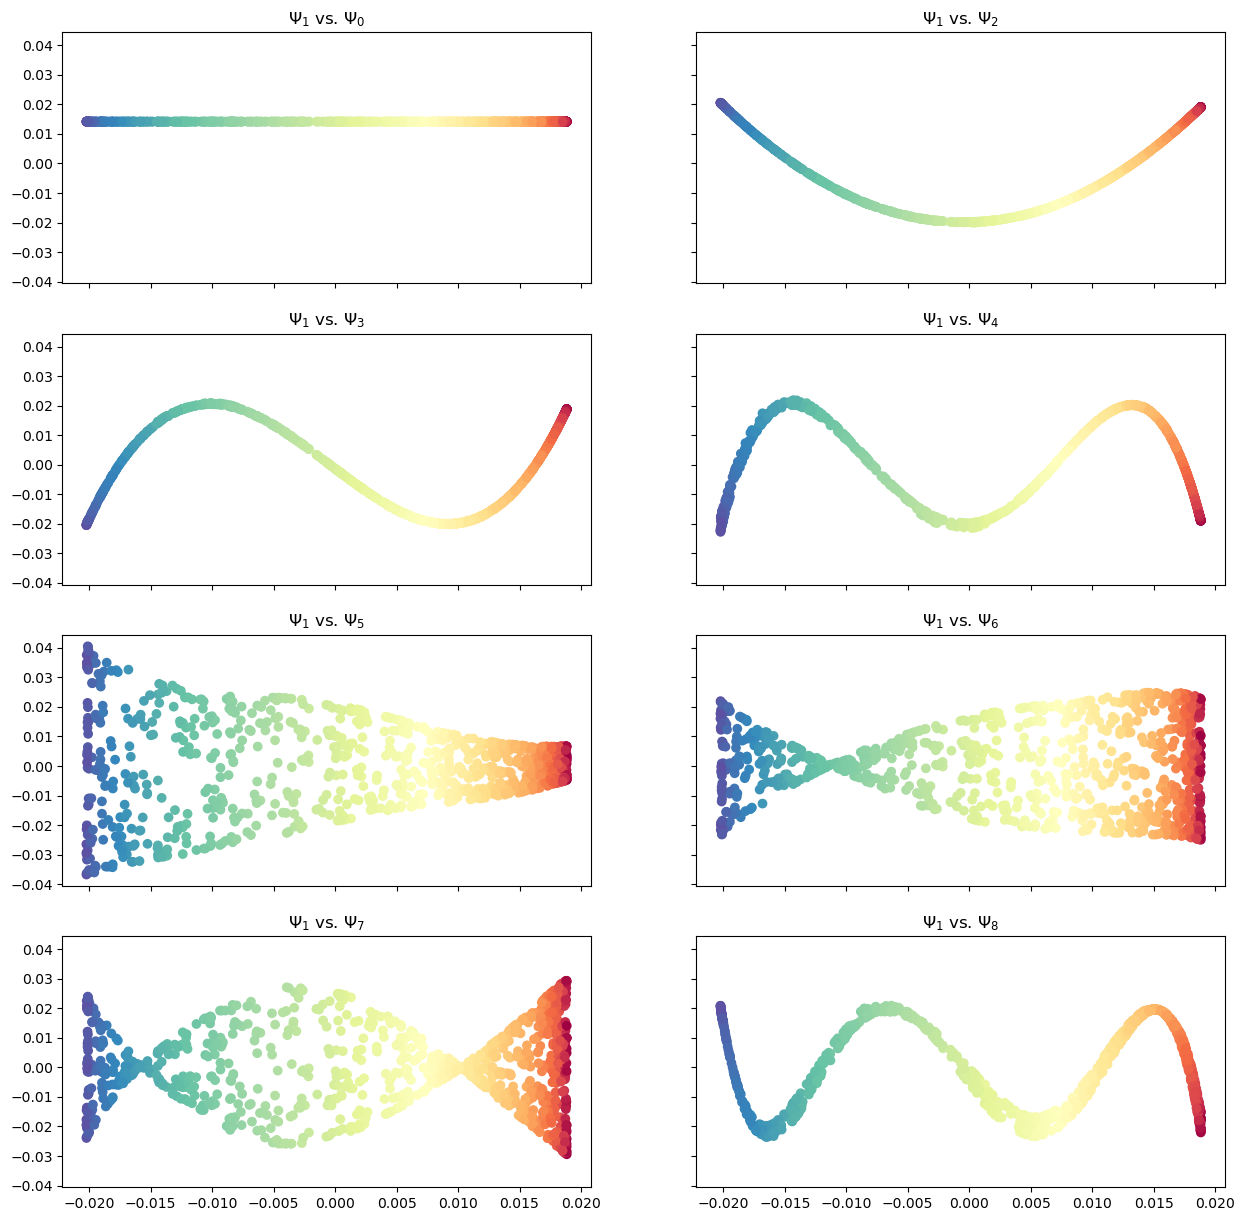

In [12]:
dmap = dfold.DiffusionMaps(
    kernel=pfold.GaussianKernel(
        epsilon=X_pcm.kernel.epsilon, distance=dict(cut_off=X_pcm.cut_off)
    ),
    n_eigenpairs=9,
)
dmap = dmap.fit(X_pcm)
evecs, evals = dmap.eigenvectors_, dmap.eigenvalues_

plot_pairwise_eigenvector(
    eigenvectors=dmap.eigenvectors_[idx_plot, :],
    n=1,
    fig_params=dict(figsize=[15, 15]),
    scatter_params=dict(cmap=plt.cm.Spectral, c=X_color[idx_plot]),
)

# Compute accuracy
diffMap = model.DiffusionMap()
print(diffMap.acc(X, dmap.eigenvectors_[:, 1], dmap.eigenvectors_[:, 5]))

## Automatic embedding selection

In the visual comparison, we can identify good choices if the dimension is low (two dimensional for plotting). For larger (intrinsic) dimensions of the manifold, this becomes much harder or impossible. Furthermore, we also wish to automatize this process.

In a (linear) Principal Component Analysis (PCA), the eigenvectors are sorted by relevance and each eigenvector points in the direction of (next) larger variance. This is a property by construction and because of this intrinsic order, the selection process is simpler as we only have to look at the magnitude of corresponding eigenvalues or a gap in the eigenvalues. 

For manifold learning models like `DiffusionMaps` we trade-off lower-dimensional embeddings (by accounting for non-linearity) with a harder selection process. The eigenvectors with large eigenvalue may not add new information compared to the previous eigenvectors (as in the plot above). For an automatic selection of suitable eigenvector coordinates, we need a model that quantifies what a "good" embedding is and optimize for this quantity. 

An automatic selection model is provided in `datafold.dynfold.LocalRegressionSelection`. It provides two strategies ("fixed dimension" or "threshold"). Because we know *apriori* that the intrinsic dimension is two, we choose this strategy.

In [13]:
selection = LocalRegressionSelection(
    intrinsic_dim=2, n_subsample=500, strategy="dim"
).fit(dmap.eigenvectors_)
print(f"Found parsimonious eigenvectors (indices): {selection.evec_indices_}")

Found parsimonious eigenvectors (indices): [1 5]


We see that the selection-model was able to find the same eigenvector pairs for embedding that we identified as the best choice before. Finally, we plot the unfolded point cloud:

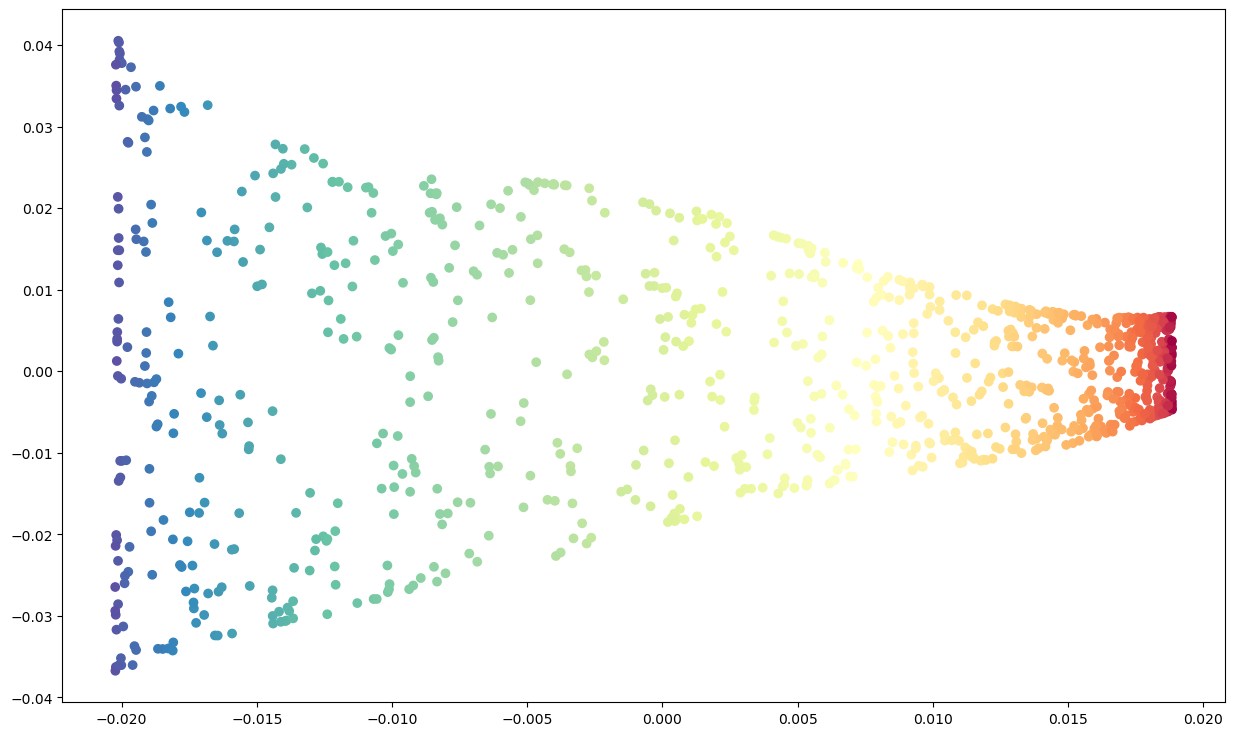

In [14]:
target_mapping = selection.transform(dmap.eigenvectors_)

f, ax = plt.subplots(figsize=(15, 9))
ax.scatter(
    target_mapping[idx_plot, 0],
    target_mapping[idx_plot, 1],
    c=X_color[idx_plot],
    cmap=plt.cm.Spectral,
);